In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
insurance_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TensorFlow/My Projects/Medical Insurance with Regression/Datasets/insurance.csv")

In [5]:
insurance_data = pd.get_dummies(insurance_data)
insurance_data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [6]:
X = insurance_data.drop(labels=['charges'], axis=1)
y = insurance_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
tf.random.set_seed(42)
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=30)
insurance_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(150),                                
    tf.keras.layers.Dense(150),
    tf.keras.layers.Dense(150),
    tf.keras.layers.Dense(1)  # important for output layer
])

insurance_model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.mae,
    metrics=["mae"]
)

history = insurance_model_1.fit(X_train, y_train, epochs=20000, verbose=0, callbacks=[callback])
insurance_model_1.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 3161.8279 - mae: 3161.8279


[3161.827880859375, 3161.827880859375]

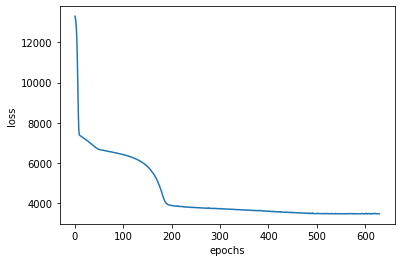

In [31]:
pd.DataFrame(history.history)['loss'].plot()
plt.xlabel("epochs")
plt.ylabel("loss");

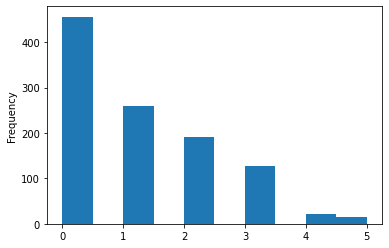

In [46]:
# plt.hist(X_train['age'])
X_train['children'].plot(kind='hist');

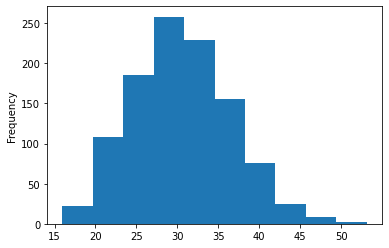

In [40]:
X_train['bmi'].plot(kind='hist');

In [3]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [4]:
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
    )

X = insurance_data.drop(labels=['charges'], axis=1)
y = insurance_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct.fit(X_train)
# why training data? because this will learn the patterns and then apply them to normalize
# validation or test data, as well as the data we want to use to make predictions

# note: can use  ct.fit_transform(X_train) above to skip transforming X_train later
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [76]:
tf.random.set_seed(42)
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(150),                                
  tf.keras.layers.Dense(150),
  tf.keras.layers.Dense(150),
  tf.keras.layers.Dense(25),
  tf.keras.layers.Dense(1)
])

insurance_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss="mae",
                          metrics=["mae"])

history = insurance_model_2.fit(X_train_normal, y_train, epochs=300, verbose=0, callbacks=[callback])

9/9 [==============================] - 0s 2ms/step - loss: 3163.6067 - mae: 3163.6067


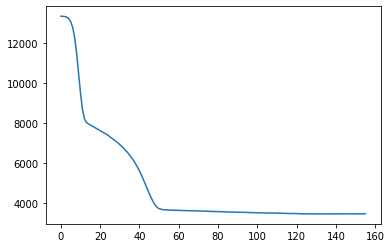

In [77]:
insurance_model_2.evaluate(X_test_normal, y_test), pd.DataFrame(history.history)['loss'].plot();
# close results to insurance_model_1 but with less epochs
# the big change was made by noramlizing the data

In [86]:
insurance_model_2.save(
    "/content/drive/MyDrive/Colab Notebooks/TensorFlow/My Projects/Medical Insurance with Regression/Models/HDF5 Format/insurance_model_2.h5"
)
insurance_model_2.save(
    "/content/drive/MyDrive/Colab Notebooks/TensorFlow/My Projects/Medical Insurance with Regression/Models/SavedModel Format/insurance_model_2"
)


loaded_model_HDF5 = tf.keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/TensorFlow/My Projects/Medical Insurance with Regression/Models/HDF5 Format/insurance_model_2.h5"
)
loaded_model_SaveModel = tf.keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/TensorFlow/My Projects/Medical Insurance with Regression/Models/SavedModel Format/insurance_model_2"
)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TensorFlow/My Projects/Medical Insurance with Regression/Models/SavedModel Format/insurance_model_2/assets


In [89]:
import numpy as np
np.testing.assert_allclose(
    insurance_model_2.predict(X_test_normal),
    loaded_model_SaveModel.predict(X_test_normal)
)
# no error

In [90]:
np.testing.assert_allclose(
    insurance_model_2.predict(X_test_normal),
    loaded_model_HDF5.predict(X_test_normal)
)
# no error